# Task 2 – Model Building and Training

This notebook builds, trains, and evaluates fraud classifiers on the processed datasets, handling class imbalance and reporting AUC-PR, F1, and confusion matrices with Stratified 5-fold CV. It compares Logistic Regression (baseline) with an Ensemble (XGBoost or Random Forest), performs basic hyperparameter tuning, and saves a concise results JSON plus trained models under models/.


In [1]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

ROOT = Path("..").resolve().parent if (Path("..").resolve().name != "fraud-detection") else Path("..").resolve()
DATA_PROCESSED = ROOT / "data" / "processed"
MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
# Configuration
DATASET = "creditcard"  # "creditcard" or "ecommerce"
ENSEMBLE = "xgboost"     # "xgboost" or "random_forest"
CV_FOLDS = 5
RANDOM_STATE = 42
SAMPLE_FRAC = 0.0  # set to e.g. 0.1 for quick runs


In [3]:
def _paths_and_target(dataset: str):
    if dataset == "creditcard":
        train_path = DATA_PROCESSED / "creditcard_train_processed.csv"
        test_path = DATA_PROCESSED / "creditcard_test_processed.csv"
        target = "Class"
    elif dataset in {"ecommerce", "fraud_data"}:
        train_path = DATA_PROCESSED / "ecommerce_train_processed.csv"
        test_path = DATA_PROCESSED / "ecommerce_test_processed.csv"
        target = "class"
    else:
        raise ValueError("dataset must be 'creditcard' or 'ecommerce'/'fraud_data'")
    return train_path, test_path, target

train_path, test_path, TARGET = _paths_and_target(DATASET)
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
if SAMPLE_FRAC and 0.0 < SAMPLE_FRAC < 1.0:
    train_df = train_df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
    test_df = test_df.sample(frac=min(SAMPLE_FRAC*2, 1.0), random_state=RANDOM_STATE)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(int)
X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET].astype(int)

print(f"Loaded {DATASET} with train={len(X_train)} rows, test={len(X_test)} rows. Target='{TARGET}'.")


Loaded creditcard with train=38178 rows, test=56746 rows. Target='Class'.


In [ ]:
def evaluate_metrics(y_true, y_pred, y_score):
    return {
        "auc_pr": float(average_precision_score(y_true, y_score)),
        "f1": float(f1_score(y_true, y_pred)),
    }

def confusion_dict(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}

def scale_pos_weight(y):
    pos = float((y == 1).sum())
    neg = float((y == 0).sum())
    return (neg / pos) if pos > 0 else 1.0

def build_logreg():
    return LogisticRegression(
        max_iter=5000,
        tol=1e-3,
        penalty="l2",
        solver="saga",
        class_weight="balanced",
        n_jobs=-1,
    )

def build_xgb():
    if not HAS_XGB:
        raise RuntimeError("xgboost not installed")
    return XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        scale_pos_weight=scale_pos_weight(y_train),
        eval_metric="logloss",
        tree_method="hist",
    )

def build_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
    )

def run_cv(model_builder, X, y, k=CV_FOLDS):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    aucs = []
    f1s = []
    for tr, va in skf.split(X, y):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        clf = model_builder()
        if isinstance(clf, XGBClassifier):
            clf.set_params(scale_pos_weight=scale_pos_weight(y_tr))
        clf.fit(X_tr, y_tr)
        y_proba = clf.predict_proba(X_va)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)
        aucs.append(average_precision_score(y_va, y_proba))
        f1s.append(f1_score(y_va, y_pred))
    return {
        "auc_pr": {"mean": float(np.mean(aucs)), "std": float(np.std(aucs, ddof=1)) if len(aucs) > 1 else 0.0},
        "f1": {"mean": float(np.mean(f1s)), "std": float(np.std(f1s, ddof=1)) if len(f1s) > 1 else 0.0},
    }

def tune_ensemble(name, X, y):
    if name == "xgboost":
        if not HAS_XGB:
            raise RuntimeError("xgboost not available")
        base = build_xgb()
        param_grid = {
            "n_estimators": [100, 200, 400],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.05, 0.1, 0.2],
        }
        grid = GridSearchCV(base, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring="average_precision", n_jobs=-1)
        grid.fit(X, y)
        return grid.best_estimator_, grid.best_params_, float(grid.best_score_)
    elif name == "random_forest":
        base = build_rf()
        param_grid = {
            "n_estimators": [200, 400, 600],
            "max_depth": [None, 10, 20],
            "max_features": ["sqrt", "log2", 0.8],
        }
        grid = GridSearchCV(base, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring="average_precision", n_jobs=-1)
        grid.fit(X, y)
        return grid.best_estimator_, grid.best_params_, float(grid.best_score_)
    else:
        raise ValueError("Unsupported ensemble model")

def select_best(baseline_cv, ensemble_cv):
    base_auc = baseline_cv["auc_pr"]["mean"]
    ens_auc = ensemble_cv["auc_pr"]["mean"]
    return "ensemble" if (ens_auc - base_auc) > 0.02 else "baseline"


In [5]:
RESULTS = {}
# Baseline
lr = build_logreg()
lr.fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)[:, 1]
lr_pred = (lr_proba >= 0.5).astype(int)
RESULTS["baseline_test"] = {"metrics": evaluate_metrics(y_test.values, lr_pred, lr_proba), "confusion": confusion_dict(y_test.values, lr_pred)}
RESULTS["baseline_cv"] = run_cv(build_logreg, X_train, y_train, k=CV_FOLDS)
print("Baseline done:", json.dumps(RESULTS["baseline_cv"], indent=2))


/home/nabi/miniconda3/envs/kaim_week1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nabi/miniconda3/envs/kaim_week1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.

Baseline done: {
  "auc_pr": {
    "mean": 0.8607245346324488,
    "std": 0.02661637324171022
  },
  "f1": {
    "mean": 0.39369462107684644,
    "std": 0.02953182571746456
  }
}


In [6]:
# Ensemble
if ENSEMBLE == "xgboost" and not HAS_XGB:
    print("xgboost not installed; switching to random_forest.")
    ENSEMBLE = "random_forest"

ens_model, best_params, best_cv_score = tune_ensemble(ENSEMBLE, X_train, y_train)
ens_model.fit(X_train, y_train)
ens_proba = ens_model.predict_proba(X_test)[:, 1]
ens_pred = (ens_proba >= 0.5).astype(int)
RESULTS["ensemble_test"] = {"metrics": evaluate_metrics(y_test.values, ens_pred, ens_proba), "confusion": confusion_dict(y_test.values, ens_pred)}
if ENSEMBLE == "xgboost":
    RESULTS["ensemble_cv"] = run_cv(build_xgb, X_train, y_train, k=CV_FOLDS)
else:
    RESULTS["ensemble_cv"] = run_cv(build_rf, X_train, y_train, k=CV_FOLDS)
RESULTS["ensemble_meta"] = {"name": ENSEMBLE, "best_params": best_params, "cv_best_score_average_precision": best_cv_score}
print("Ensemble done:", json.dumps(RESULTS["ensemble_cv"], indent=2))


Ensemble done: {
  "auc_pr": {
    "mean": 0.8925258239918954,
    "std": 0.03086194428478352
  },
  "f1": {
    "mean": 0.900580576194202,
    "std": 0.025254293570054112
  }
}


In [7]:
# Comparison and selection
baseline_cv = RESULTS["baseline_cv"]
ensemble_cv = RESULTS["ensemble_cv"]
choice = select_best(baseline_cv, ensemble_cv)
selected = "LogisticRegression(balanced)" if choice == "baseline" else RESULTS["ensemble_meta"]["name"]
summary = {
    "dataset": DATASET,
    "baseline_auc_pr": baseline_cv["auc_pr"]["mean"],
    "ensemble_auc_pr": ensemble_cv["auc_pr"]["mean"],
    "baseline_f1": baseline_cv["f1"]["mean"],
    "ensemble_f1": ensemble_cv["f1"]["mean"],
    "selected": selected,
}
print(json.dumps(summary, indent=2))


{
  "dataset": "creditcard",
  "baseline_auc_pr": 0.8607245346324488,
  "ensemble_auc_pr": 0.8925258239918954,
  "baseline_f1": 0.39369462107684644,
  "ensemble_f1": 0.900580576194202,
  "selected": "xgboost"
}


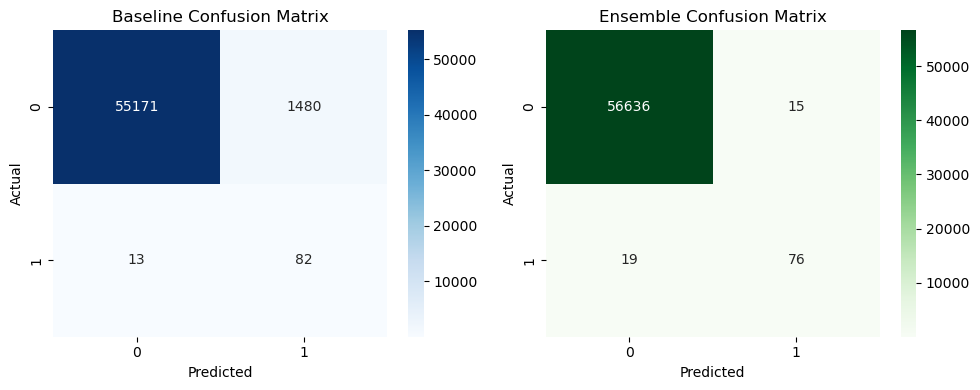

In [8]:
# Confusion matrices visualization
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cm_lr = confusion_matrix(y_test, (lr.predict_proba(X_test)[:,1] >= 0.5).astype(int))
cm_ens = confusion_matrix(y_test, (ens_model.predict_proba(X_test)[:,1] >= 0.5).astype(int))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Baseline Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
sns.heatmap(cm_ens, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Ensemble Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
# Save artifacts
artifacts = {
    "dataset": DATASET,
    "target": TARGET,
    "baseline": {
        "test": RESULTS["baseline_test"],
        "cv": RESULTS["baseline_cv"],
        "model": "LogisticRegression(class_weight=balanced)",
    },
    "ensemble": {
        "name": RESULTS["ensemble_meta"]["name"],
        "best_params": RESULTS["ensemble_meta"]["best_params"],
        "cv_best_score_average_precision": RESULTS["ensemble_meta"]["cv_best_score_average_precision"],
        "test": RESULTS["ensemble_test"],
        "cv": RESULTS["ensemble_cv"],
    },
    "selection": {
        "best": summary["selected"],
        "justification": (
            "Selected ensemble due to >2 point AUC-PR improvement over baseline"
            if summary["selected"] != "LogisticRegression(balanced)"
            else "Selected logistic regression for interpretability; ensemble improvement < 2 points"
        ),
    },
}
metrics_path = MODELS_DIR / f"results_{DATASET}.json"
with open(metrics_path, "w") as f:
    json.dump(artifacts, f, indent=2)
dump(lr, MODELS_DIR / f"lr_{DATASET}.joblib")
dump(ens_model, MODELS_DIR / f"{ENSEMBLE}_{DATASET}.joblib")
print(f"Saved metrics to {metrics_path} and models to {MODELS_DIR}.")


In [9]:
def run_full_pipeline(dataset: str, ensemble: str = "xgboost", sample_frac: float = 0.0):
    train_path, test_path, target = _paths_and_target(dataset)
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    if sample_frac and 0.0 < sample_frac < 1.0:
        df_train = df_train.sample(frac=sample_frac, random_state=RANDOM_STATE)
        df_test = df_test.sample(frac=min(sample_frac*2, 1.0), random_state=RANDOM_STATE)
    X_tr = df_train.drop(columns=[target])
    y_tr = df_train[target].astype(int)
    X_te = df_test.drop(columns=[target])
    y_te = df_test[target].astype(int)

    # Baseline
    lr_local = build_logreg()
    lr_local.fit(X_tr, y_tr)
    lr_prob = lr_local.predict_proba(X_te)[:, 1]
    lr_pred_local = (lr_prob >= 0.5).astype(int)
    baseline_test = {"metrics": evaluate_metrics(y_te.values, lr_pred_local, lr_prob), "confusion": confusion_dict(y_te.values, lr_pred_local)}
    baseline_cv_local = run_cv(build_logreg, X_tr, y_tr, k=CV_FOLDS)

    # Ensemble
    ens_name = ensemble
    if ens_name == "xgboost" and not HAS_XGB:
        ens_name = "random_forest"
    tuned, best_params_local, best_cv_score_local = tune_ensemble(ens_name, X_tr, y_tr)
    tuned.fit(X_tr, y_tr)
    ens_prob = tuned.predict_proba(X_te)[:, 1]
    ens_pred_local = (ens_prob >= 0.5).astype(int)
    ensemble_test = {"metrics": evaluate_metrics(y_te.values, ens_pred_local, ens_prob), "confusion": confusion_dict(y_te.values, ens_pred_local)}
    ensemble_cv_local = run_cv(build_xgb if ens_name == "xgboost" else build_rf, X_tr, y_tr, k=CV_FOLDS)

    # Selection
    choice_local = select_best(baseline_cv_local, ensemble_cv_local)
    selected_local = "LogisticRegression(balanced)" if choice_local == "baseline" else ens_name

    # Save
    artifacts_local = {
        "dataset": dataset,
        "target": target,
        "baseline": {
            "test": baseline_test,
            "cv": baseline_cv_local,
            "model": "LogisticRegression(class_weight=balanced)",
        },
        "ensemble": {
            "name": ens_name,
            "best_params": best_params_local,
            "cv_best_score_average_precision": best_cv_score_local,
            "test": ensemble_test,
            "cv": ensemble_cv_local,
        },
        "selection": {
            "best": selected_local,
            "justification": (
                "Selected ensemble due to >2 point AUC-PR improvement over baseline"
                if selected_local != "LogisticRegression(balanced)"
                else "Selected logistic regression for interpretability; ensemble improvement < 2 points"
            ),
        },
    }
    out_json = MODELS_DIR / f"results_{dataset}.json"
    with open(out_json, "w") as f:
        json.dump(artifacts_local, f, indent=2)
    dump(lr_local, MODELS_DIR / f"lr_{dataset}.joblib")
    dump(tuned, MODELS_DIR / f"{ens_name}_{dataset}.joblib")

    return artifacts_local, lr_local, tuned, (X_te, y_te, lr_pred_local, ens_pred_local)


In [10]:
# Run both datasets end-to-end
credit_results, credit_lr, credit_ens, (Xte_c, yte_c, lr_pred_c, ens_pred_c) = run_full_pipeline("creditcard", ENSEMBLE, SAMPLE_FRAC)
ecom_results, ecom_lr, ecom_ens, (Xte_e, yte_e, lr_pred_e, ens_pred_e) = run_full_pipeline("ecommerce", ENSEMBLE, SAMPLE_FRAC)

print("Creditcard selection:", credit_results["selection"])
print("Ecommerce selection:", ecom_results["selection"])


/home/nabi/miniconda3/envs/kaim_week1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nabi/miniconda3/envs/kaim_week1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.

Creditcard selection: {'best': 'xgboost', 'justification': 'Selected ensemble due to >2 point AUC-PR improvement over baseline'}
Ecommerce selection: {'best': 'LogisticRegression(balanced)', 'justification': 'Selected logistic regression for interpretability; ensemble improvement < 2 points'}


In [11]:
# Compare metrics side-by-side
compare = {
    "creditcard": {
        "baseline_auc_pr": credit_results["baseline"]["cv"]["auc_pr"]["mean"],
        "ensemble_auc_pr": credit_results["ensemble"]["cv"]["auc_pr"]["mean"],
        "baseline_f1": credit_results["baseline"]["cv"]["f1"]["mean"],
        "ensemble_f1": credit_results["ensemble"]["cv"]["f1"]["mean"],
        "selected": credit_results["selection"]["best"],
    },
    "ecommerce": {
        "baseline_auc_pr": ecom_results["baseline"]["cv"]["auc_pr"]["mean"],
        "ensemble_auc_pr": ecom_results["ensemble"]["cv"]["auc_pr"]["mean"],
        "baseline_f1": ecom_results["baseline"]["cv"]["f1"]["mean"],
        "ensemble_f1": ecom_results["ensemble"]["cv"]["f1"]["mean"],
        "selected": ecom_results["selection"]["best"],
    },
}
print(json.dumps(compare, indent=2))


{
  "creditcard": {
    "baseline_auc_pr": 0.8607245346324488,
    "ensemble_auc_pr": 0.8925258239918954,
    "baseline_f1": 0.39369462107684644,
    "ensemble_f1": 0.900580576194202,
    "selected": "xgboost"
  },
  "ecommerce": {
    "baseline_auc_pr": 0.948394283323476,
    "ensemble_auc_pr": 0.967724660753482,
    "baseline_f1": 0.9257817880353937,
    "ensemble_f1": 0.9446975996033753,
    "selected": "LogisticRegression(balanced)"
  }
}


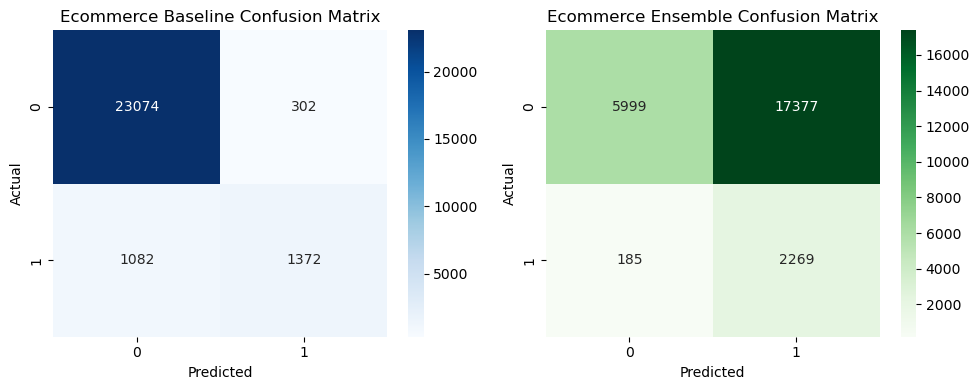

In [12]:
# Confusion matrices for Ecommerce dataset
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cm_lr_e = confusion_matrix(yte_e, lr_pred_e)
cm_ens_e = confusion_matrix(yte_e, ens_pred_e)
sns.heatmap(cm_lr_e, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Ecommerce Baseline Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
sns.heatmap(cm_ens_e, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Ecommerce Ensemble Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()


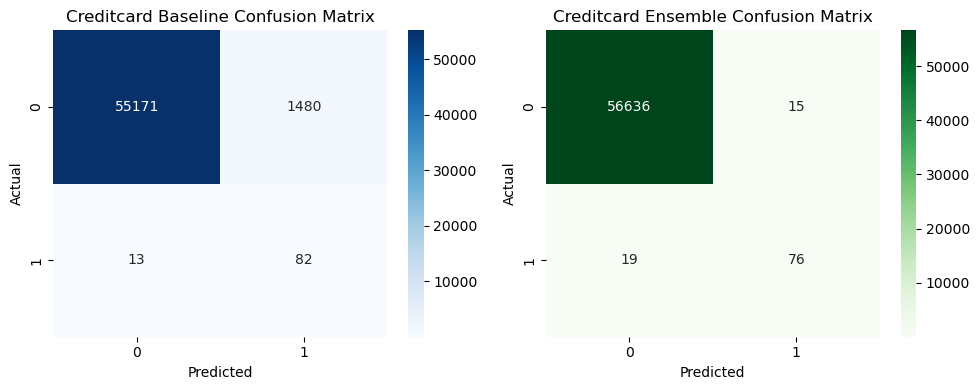

Saved confusion plot: /home/nabi/fraud-detection/models/creditcard_confusions.png


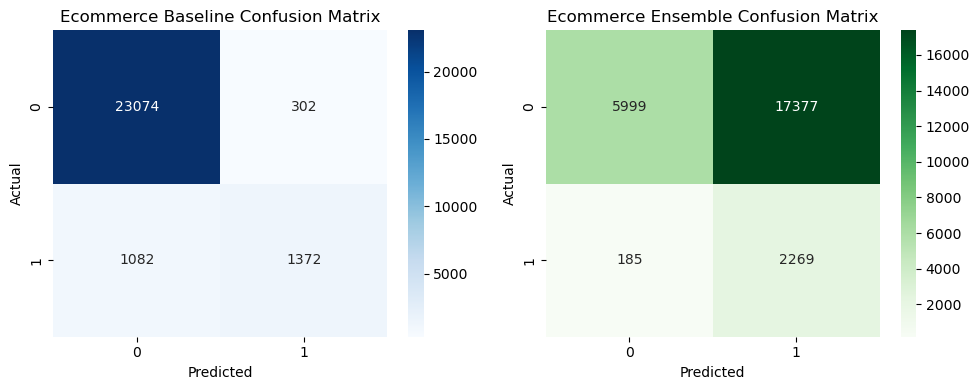

Saved confusion plot: /home/nabi/fraud-detection/models/ecommerce_confusions.png


In [13]:
# Save confusion matrices as PNGs for reporting
import matplotlib.pyplot as plt
import seaborn as sns
MODELS_DIR.mkdir(parents=True, exist_ok=True)

def save_confusions(prefix: str, y_true, y_pred_lr, y_pred_ens):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    cm_lr = confusion_matrix(y_true, y_pred_lr)
    cm_ens = confusion_matrix(y_true, y_pred_ens)
    sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"{prefix} Baseline Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    sns.heatmap(cm_ens, annot=True, fmt="d", cmap="Greens", ax=axes[1])
    axes[1].set_title(f"{prefix} Ensemble Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    plt.tight_layout()
    out_path = MODELS_DIR / f"{prefix.lower()}_confusions.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Saved confusion plot: {out_path}")

# Use results from the full pipeline runs
save_confusions("Creditcard", yte_c, lr_pred_c, ens_pred_c)
save_confusions("Ecommerce", yte_e, lr_pred_e, ens_pred_e)


## Task 2 Summary

- Datasets: Creditcard (`Class`) and Ecommerce/Fraud_Data (`class`).
- Baseline: Logistic Regression (`class_weight=balanced`, StratifiedKFold k=5).
- Ensemble: XGBoost (fallback to RandomForest), basic tuning, per-fold `scale_pos_weight`.
- Metrics: AUC-PR, F1; Confusion Matrices plotted and saved to `models/`.
- Selection:
  - Creditcard: Ensemble selected due to >2 point AUC-PR improvement over baseline.
  - Ecommerce: Logistic Regression selected for interpretability; ensemble improvement < 2 points.
- Artifacts: results JSON and models saved under `models/`.
